In [2]:
import os
import random

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

from functools import partial

import time
import scipy.stats as stats
import seaborn as sns
import arviz as az

#import constants

from tqdm import tqdm
from tqdm.auto import tqdm
tqdm.pandas()

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

pd.set_option('display.max_columns', None)

/opt/anaconda3/envs/Boda_2/lib/python3.7/site-packages/tqdm/std.py:702: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [52]:
boda2_df = pd.read_csv('/Users/castrr/Dropbox (JAX)/Datasets/BODA2/BODA2_MPRA_results_pred.txt', sep=" ", low_memory=False)

In [4]:
boda2_df

,ID,sequence,K562_pred,HepG2_pred,SKNSH_pred,K562_pred_aggreg,HepG2_pred_aggreg,SKNSH_pred_aggreg,project,K562_signal,K562_lfcSE,HepG2_signal,HepG2_lfcSE,SKNSH_signal,SKNSH_lfcSE,method,target_cell
0,20211210_200256__612928__5::fsp_uc__hepg2__0,CAATCTGTTCCCACCATCAGGTTACTGGTTAATCATTAACCAGGGC...,-0.055265,14.231705,0.080212,0.140002,14.336414,0.227027,BODA:hepg2,2.520816,0.316205,5.287727,0.309186,0.605723,0.208455,fsp_uc,hepg2
1,20211210_200256__612928__12::fsp_uc__hepg2__0,GGAGCTCTTTCAATGCCAGGCAGGCCCGTGGTGCAGTAAAGGCCTG...,-0.019169,19.914394,0.777519,-0.011601,18.561650,0.767500,BODA:hepg2,0.609272,0.285060,6.402153,0.301327,0.271218,0.340279,fsp_uc,hepg2
2,20211210_200256__612928__47::fsp_uc__hepg2__0,GGTTCAAAGTCCAGTCACAGTCCAAAGTCCACTCTTTGTCCAAGAG...,-0.146010,12.227689,-0.400996,-0.034775,10.825762,-0.337030,BODA:hepg2,1.486130,0.271874,4.276053,0.366801,-0.578350,0.241865,fsp_uc,hepg2
3,20211210_200256__612928__69::fsp_uc__hepg2__0,TAATAGTATGTCATCGTAATATGCGGACTTTGAACCGTGTACCAGG...,1.216181,18.812680,1.589409,1.416824,17.606884,1.713512,BODA:hepg2,2.440630,0.219559,5.615395,0.313984,1.063669,0.230603,fsp_uc,hepg2
4,20211210_200256__612928__93::fsp_uc__hepg2__0,AACACGGGCACGGGGGGGCGCTGTTTGAGTTTAAAAACGATCTAGG...,1.832291,18.612158,1.411221,2.409507,17.280722,2.059474,BODA:hepg2,3.765216,0.570148,4.683140,0.612207,0.171043,2.165178,fsp_uc,hepg2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120052,ORF54316:2538:1300-1500,CTCGGAGTTCAAGAAAATCATCTCACACGGCCGTCTCAGACCCTTC...,-0.119510,1.166959,-0.200713,-0.158865,1.282273,-0.275202,MPRA:ORF_negCtrl,-0.315267,0.384919,0.591628,0.363142,0.068697,0.275408,NaN,NaN
120053,ORF53130:1455:400-600,GCAATCCTACCCAGACAGATGCAGACAGCGACCTGGTGGGGGATGT...,-0.301822,-0.577524,-0.384271,-0.247987,-0.644892,-0.367910,MPRA:ORF_negCtrl,-0.134821,0.178379,-0.359782,0.261176,-0.022281,0.200300,NaN,NaN
120054,ORF55877:2391:1900-2100,CCTATGCTGCCTCCTATGCCCTTGTCATCATTGCCATTTTTGAGCT...,1.219841,1.099753,0.645146,0.524327,0.483457,0.248783,MPRA:ORF_negCtrl,0.646673,0.259927,0.489900,0.190735,0.462366,0.111966,NaN,NaN
120055,ORF52950:2193:400-600,AGCCACAACAAAACAGCCAGTTAATGTGGAAACAAGGTCGACAACT...,0.132379,0.718228,0.953675,0.085746,0.563376,0.668541,MPRA:ORF_negCtrl,-0.061676,0.171760,-0.014411,0.199712,0.239693,0.166026,NaN,NaN


In [53]:
row_filter = (boda2_df['method'] =='DHS') & (boda2_df['target_cell'] =='DHS_K')
boda2_df.loc[row_filter, 'target_cell'] = 'k562'

row_filter = (boda2_df['method'] =='DHS') & (boda2_df['target_cell'] =='DHS_H')
boda2_df.loc[row_filter, 'target_cell'] = 'hepg2'

row_filter = (boda2_df['method'] =='DHS') & (boda2_df['target_cell'] =='DHS_S')
boda2_df.loc[row_filter, 'target_cell'] = 'sknsh'

In [67]:
row_filter = (boda2_df['method'] == 'fsp') | (boda2_df['method'] == 'sa') | (boda2_df['method'] == 'al') 
round_list = [split[-1] for split in boda2_df.loc[row_filter, 'ID'].str.split('__').tolist()]
boda2_df.loc[row_filter, 'round'] = round_list

row_filter = boda2_df['ID'].str.contains('sa_rep')
boda2_df.loc[row_filter, 'method'] = 'sa_rep'

In [72]:
(boda2_df['round'] == '0').sum()

48000

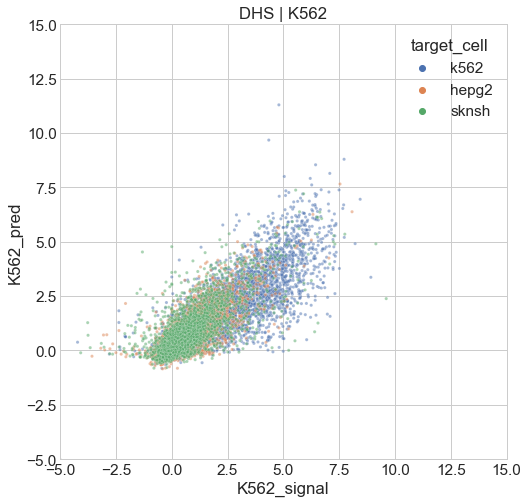

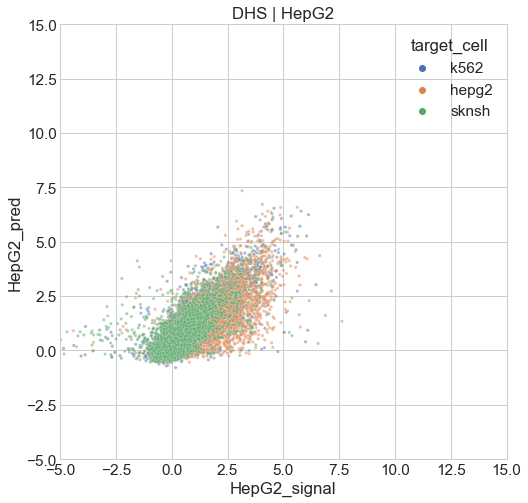

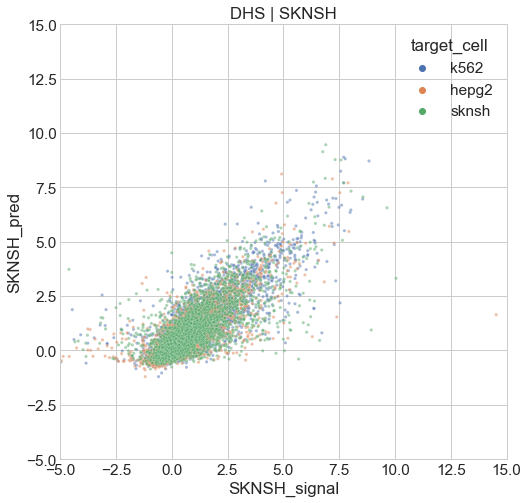

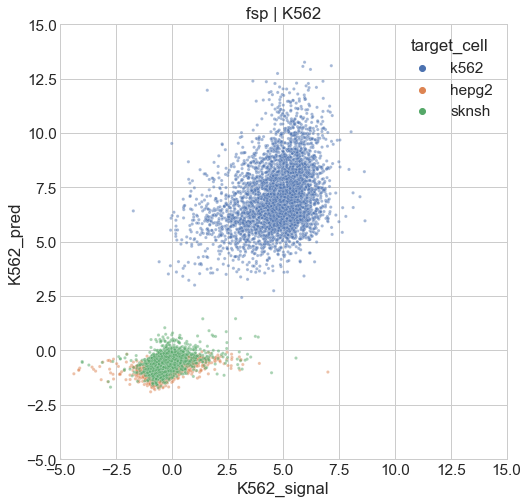

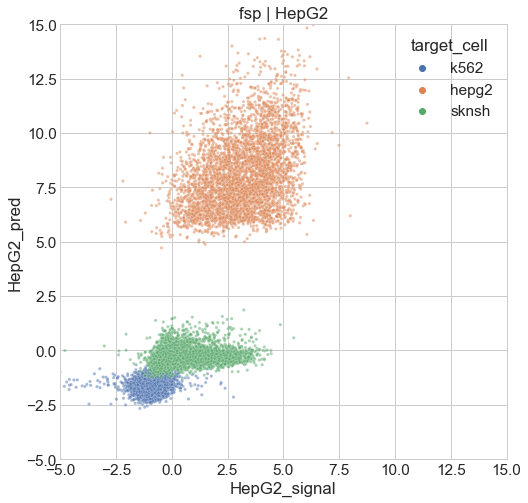

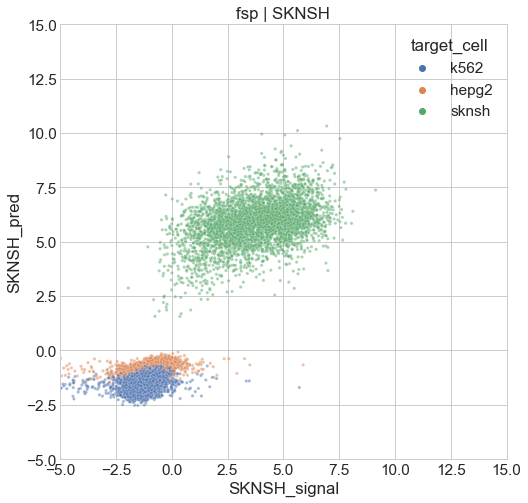

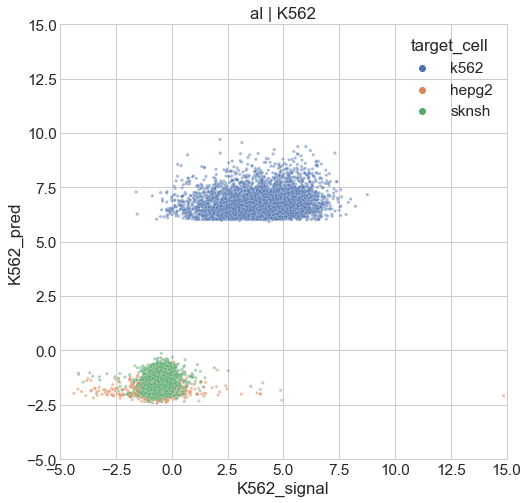

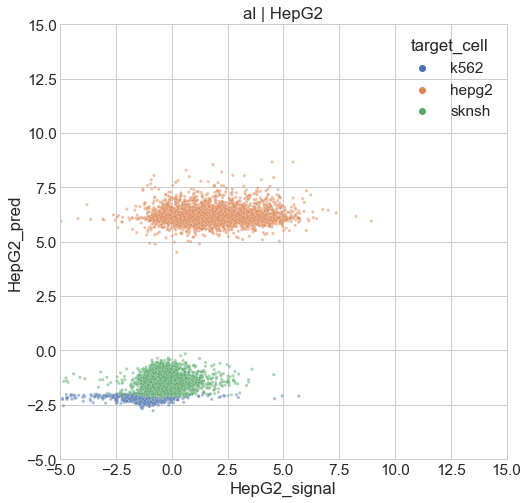

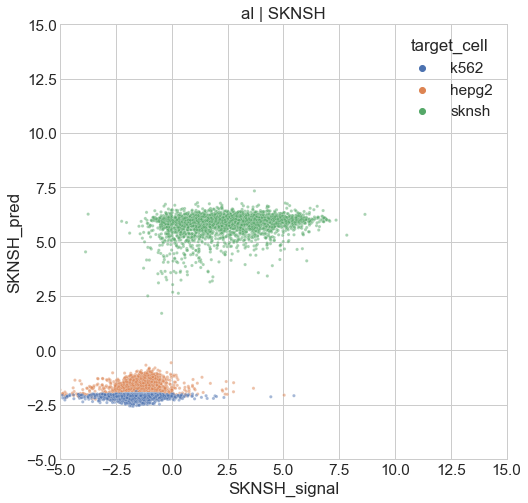

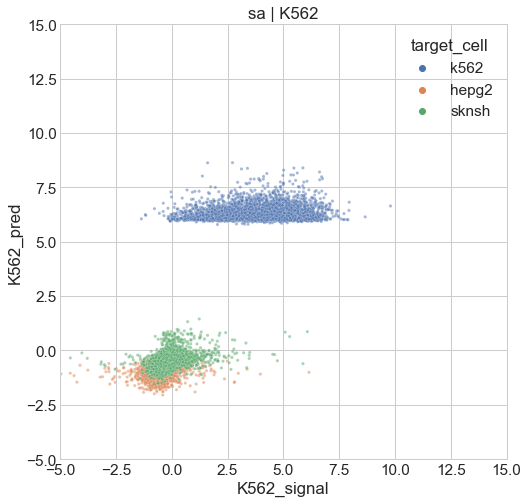

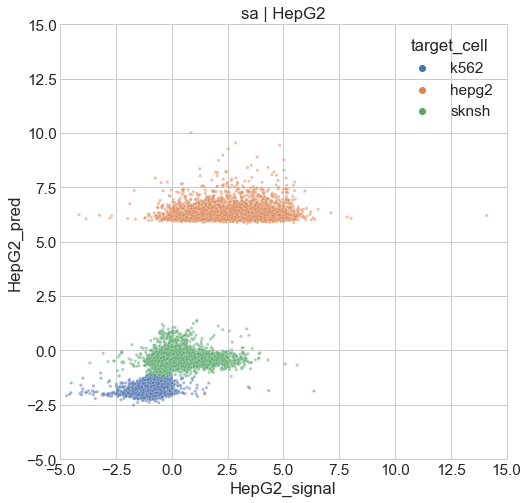

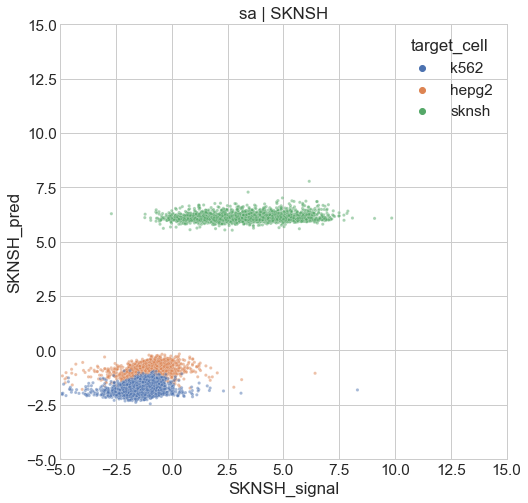

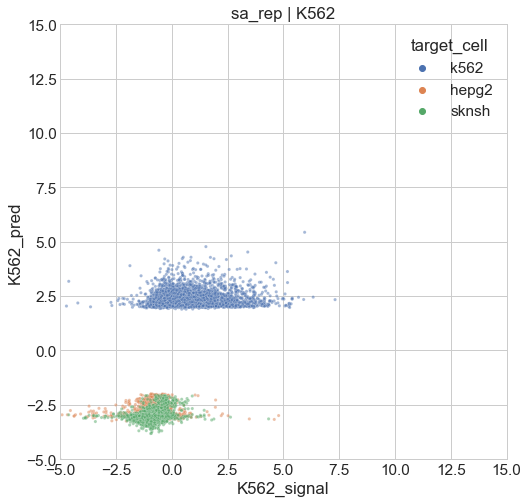

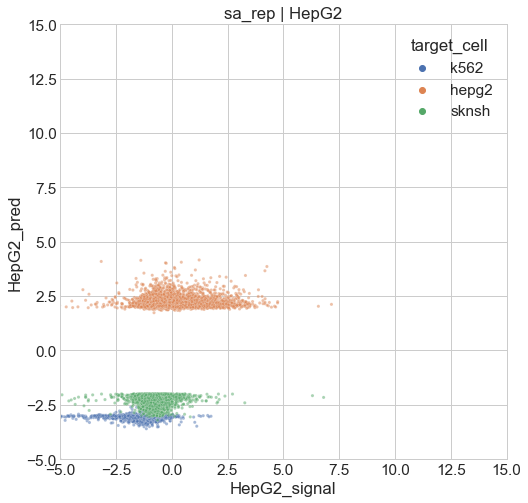

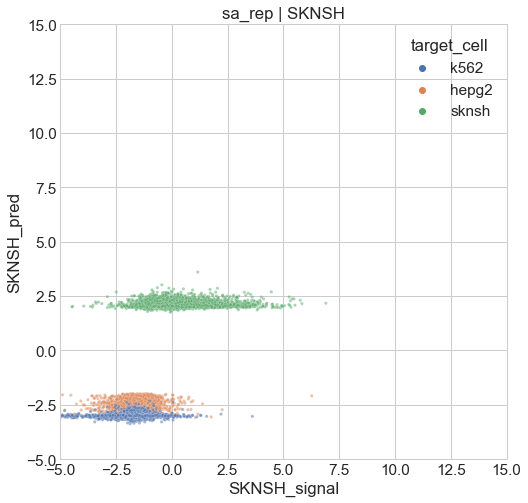

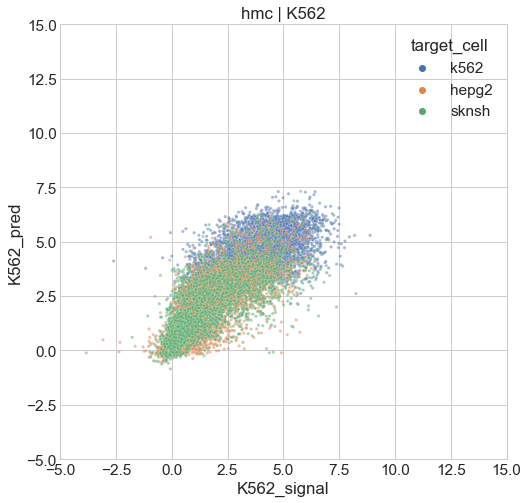

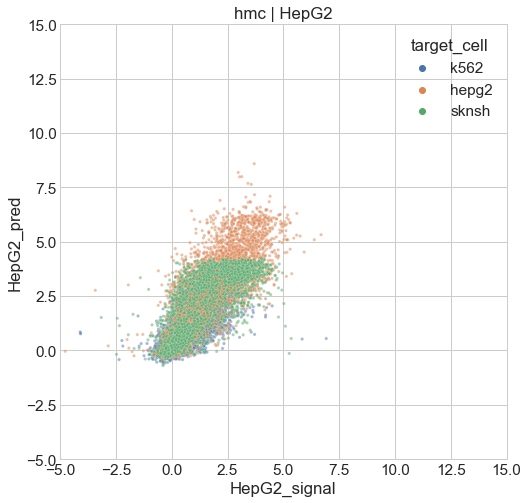

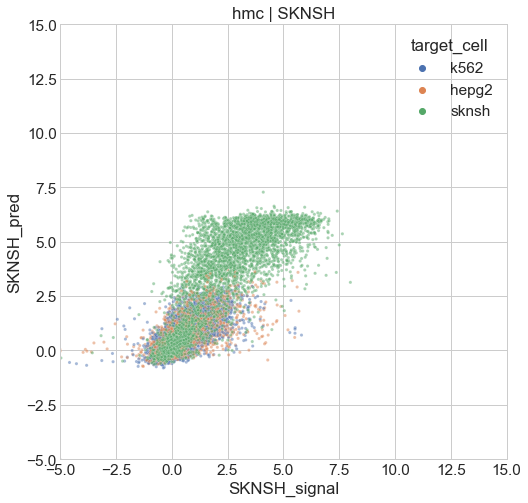

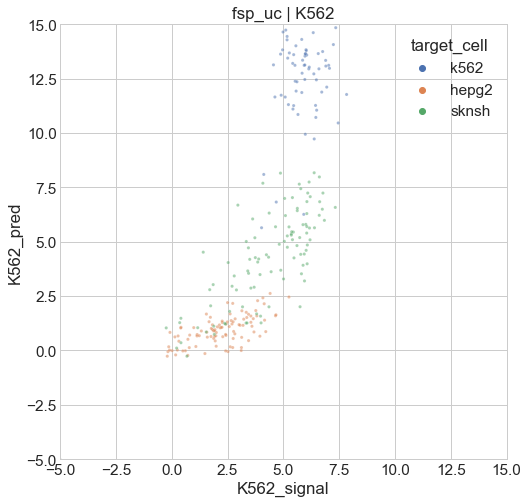

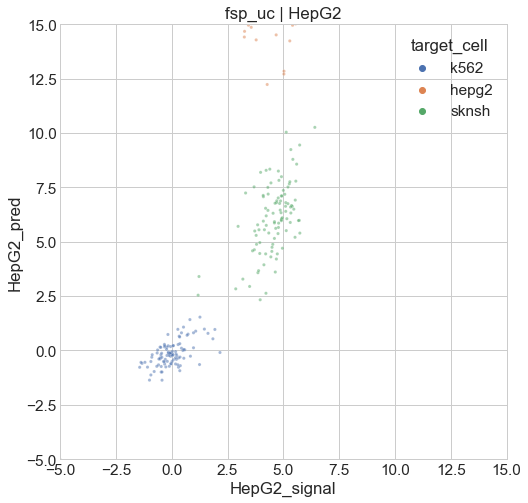

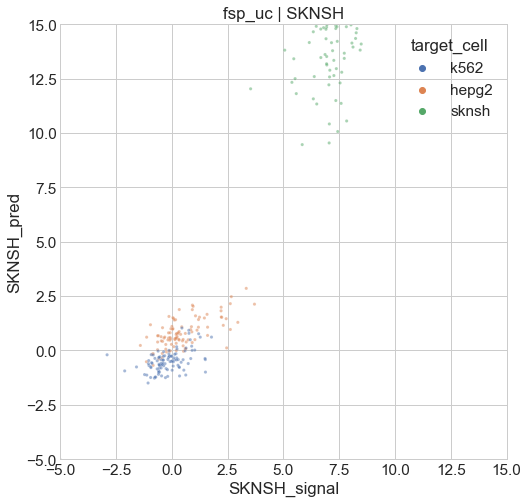

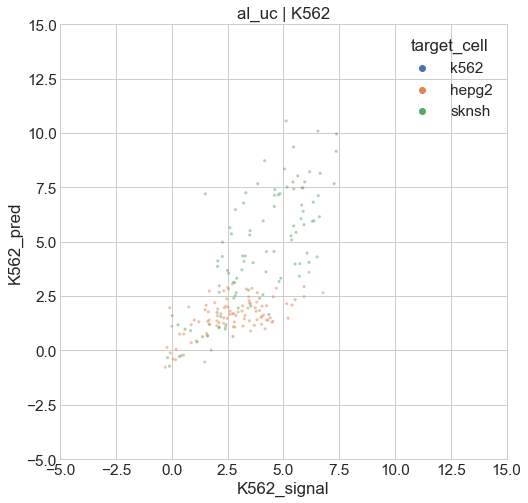

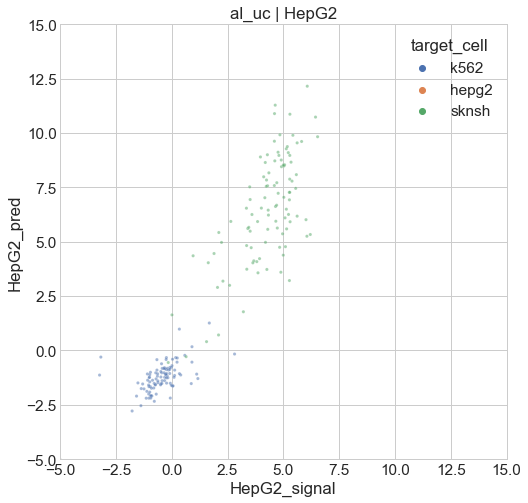

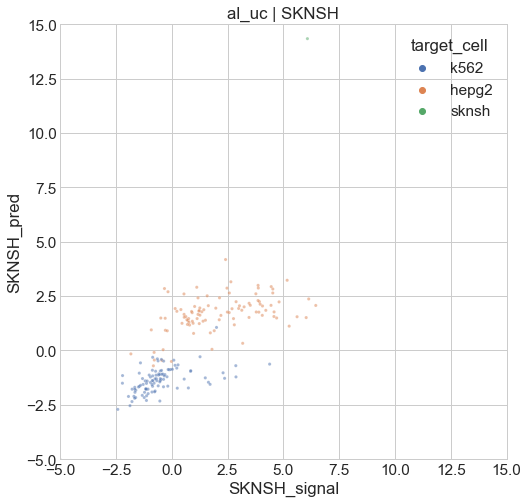

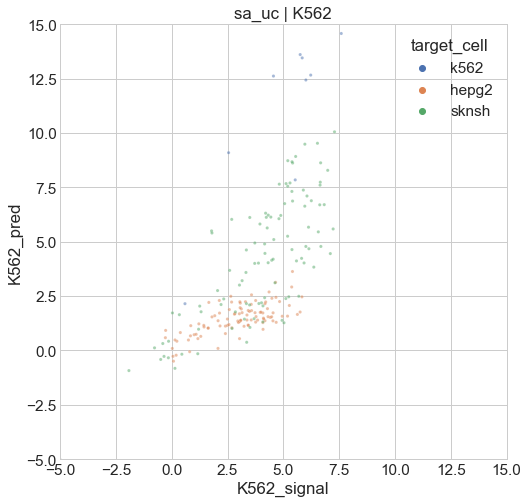

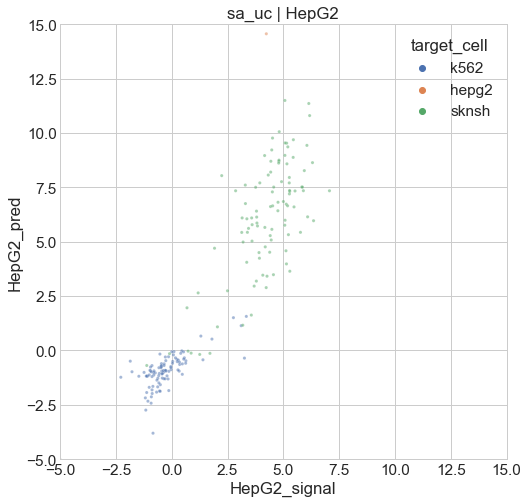

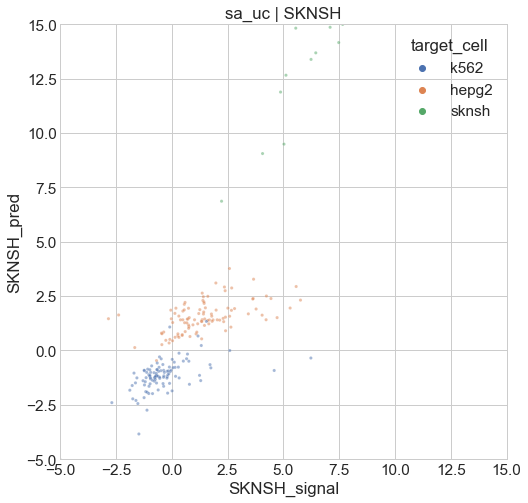

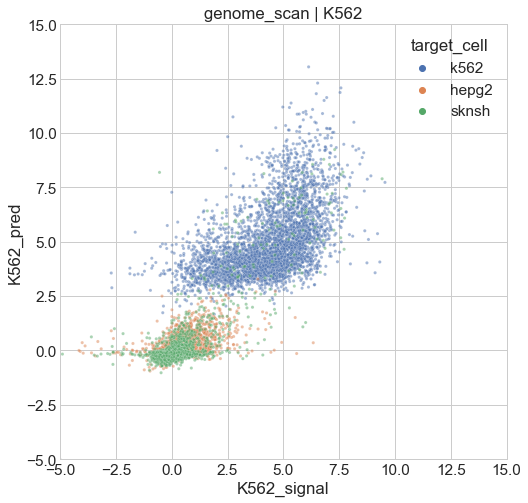

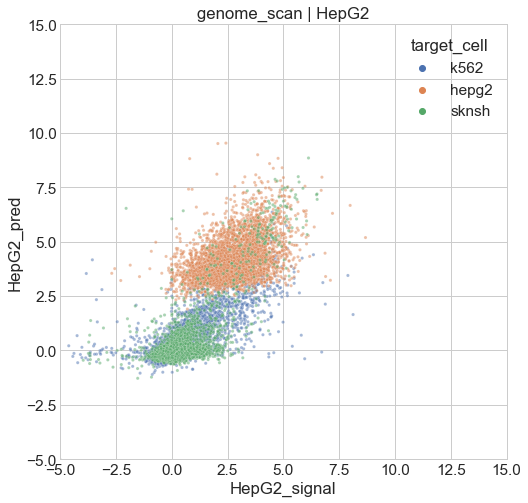

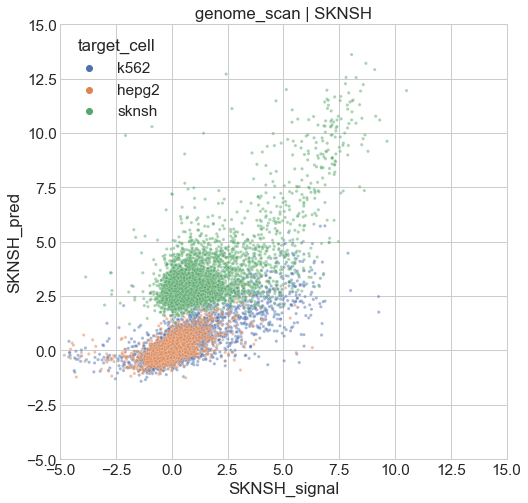

In [85]:
all_methods = ['DHS', 'fsp', 'al', 'sa', 'sa_rep', 'hmc', 'fsp_uc', 'al_uc', 'sa_uc', 'genome_scan']
cell_types = ['K562', 'HepG2', 'SKNSH']
target_cells = ['k562', 'hepg2', 'sknsh']
#colormaps = ['winter', 'autumn', 'summer']
sns.set(font_scale = 1.4)
with plt.style.context('seaborn-whitegrid'):
    for method in all_methods:
        if method in ['fsp', 'al', 'sa', 'sa_rep']:
            row_filter = (boda2_df['method'] == method) & (boda2_df['round'] == '0')
        else:
            row_filter = (boda2_df['method'] == method)
        plot_df = boda2_df[row_filter].copy()
        for color_idx, cell_type in enumerate(cell_types):   
            plt.figure(figsize=(8,8))
            sns.scatterplot(data=plot_df, x=f'{cell_type}_signal', y=f'{cell_type}_pred', hue='target_cell', s=10.0, alpha=0.5,
                           hue_order=target_cells)
            #plt.plot((-5,15), (-5,-15), color='black', linestyle='--', alpha=0.5)
            plt.xlim(-5,15)
            plt.ylim(-5,15)
            plt.title(f'{method} | {cell_type}')#, fontsize=16)
            plt.show()
            #plot_df.plot(kind='scatter', x=f'{cell_type}_signal', y= f'{cell_type}_pred', color=f'C{color_idx}')
    #         single_scatterplot(plot_df, x_axis=f'{cell_type}_signal', y_axis=f'{cell_type}_pred', color_axis=f'{cell_type}_lfcSE',
    #                         dot_size=1.0, fig_size=(12,8), colormap=colormaps[color_idx], title=f'{method}')
    #         plt.gca().set_aspect('equal', adjustable='box')
    #         plt.show()

In [108]:
print(boda2_df['K562_signal'].describe())
print(boda2_df['HepG2_signal'].describe())
print(boda2_df['SKNSH_signal'].describe())

count    118882.000000
mean          1.270605
std           2.152655
min         -18.868315
25%          -0.330528
50%           0.320598
75%           2.780962
max          19.218238
Name: K562_signal, dtype: float64
count    118882.000000
mean          0.866927
std           1.678787
min         -19.617750
25%          -0.360929
50%           0.499484
75%           1.982653
max          20.367815
Name: HepG2_signal, dtype: float64
count    118882.000000
mean          0.533028
std           2.079722
min         -19.705197
25%          -0.946665
50%           0.061799
75%           1.503133
max          21.173280
Name: SKNSH_signal, dtype: float64


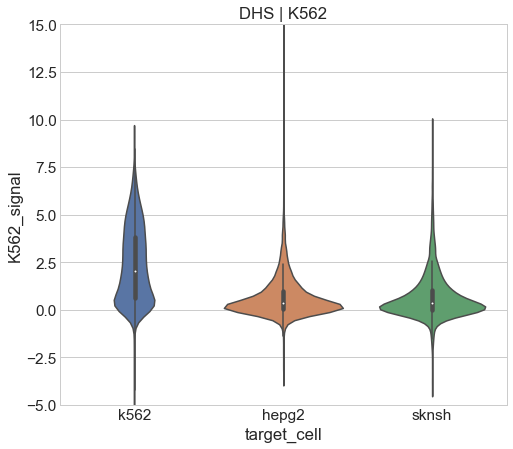

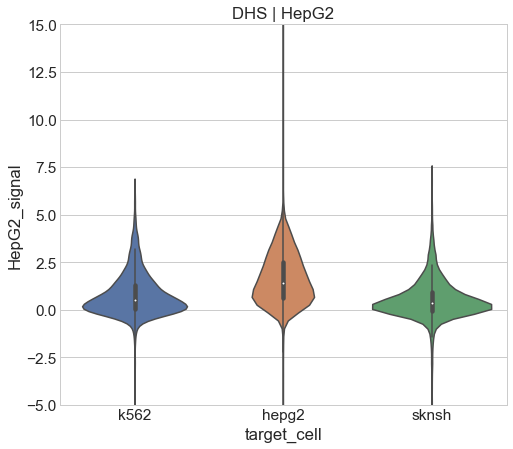

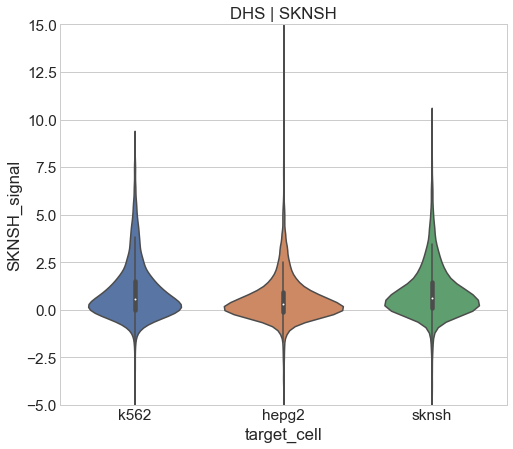

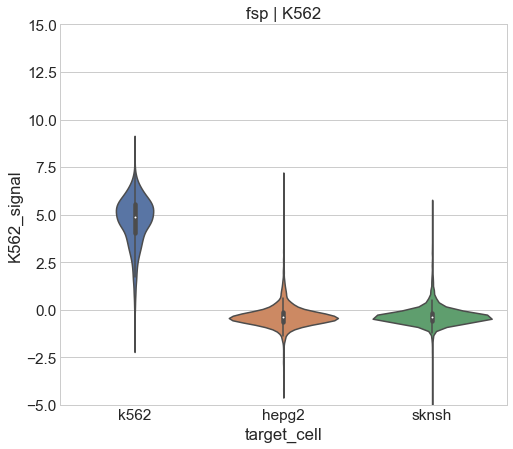

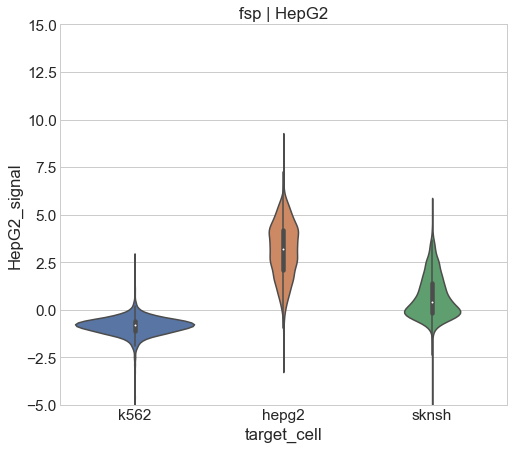

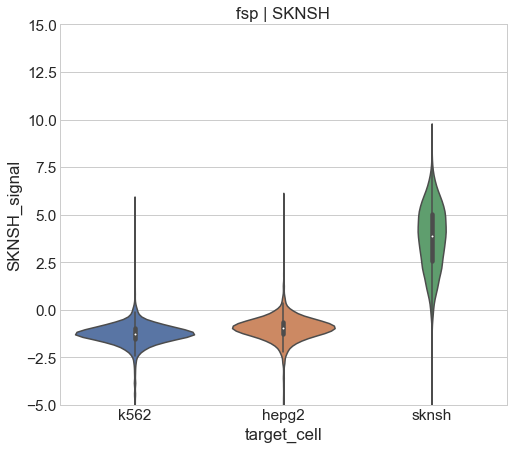

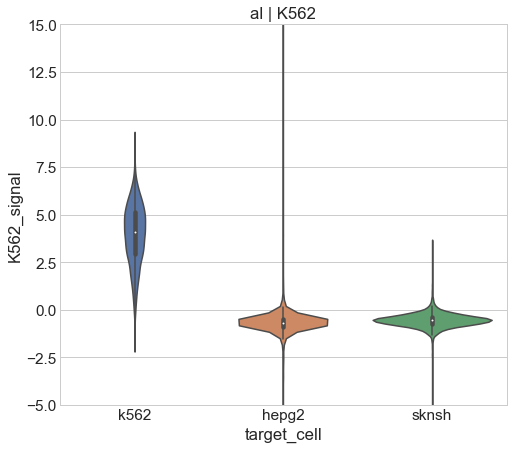

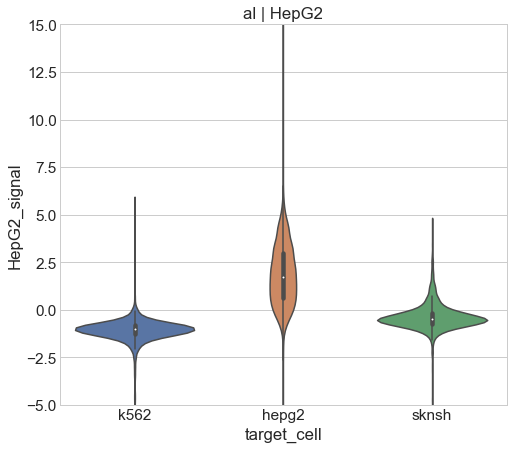

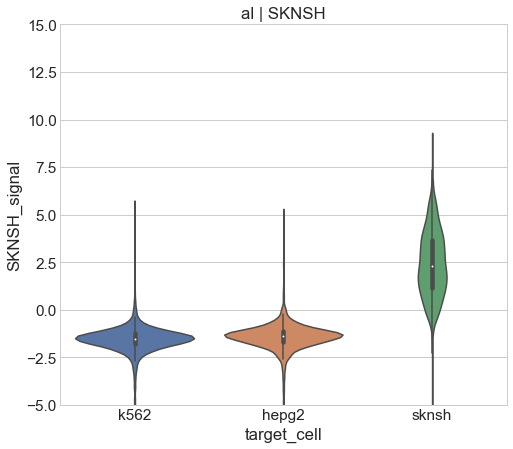

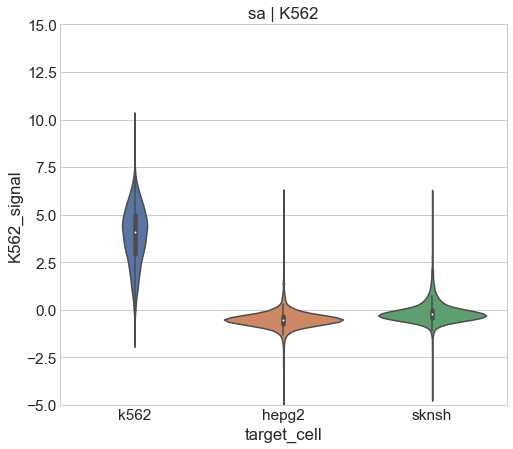

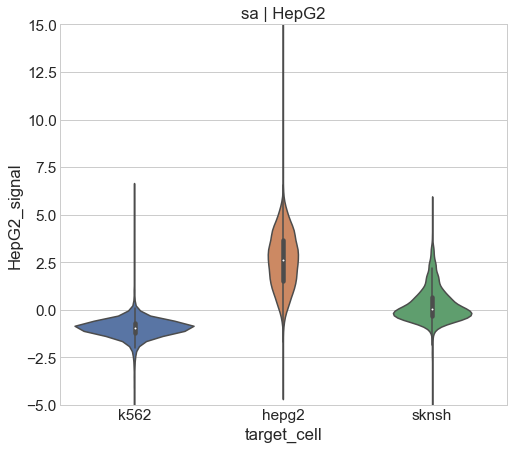

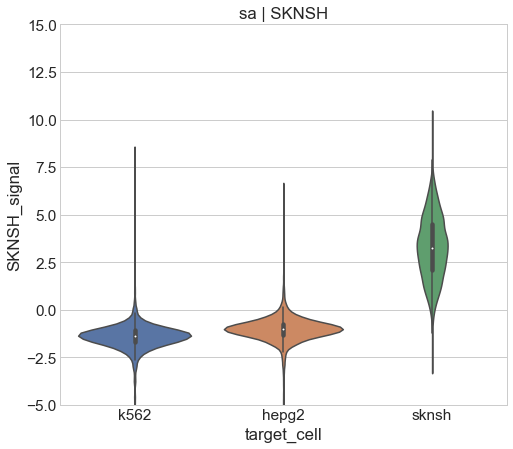

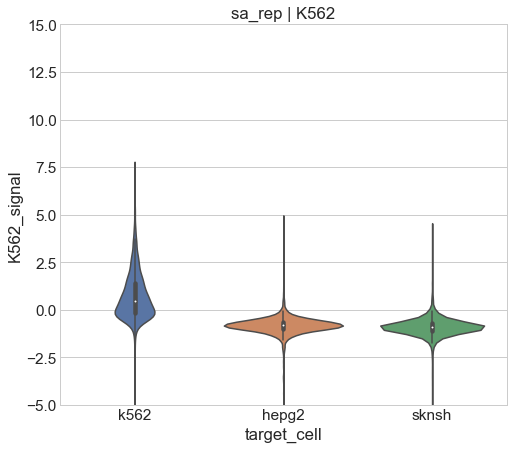

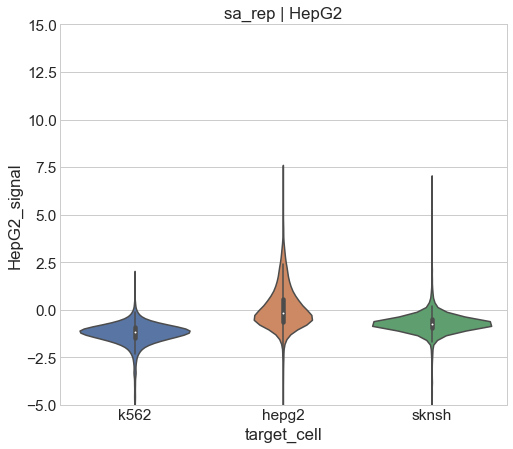

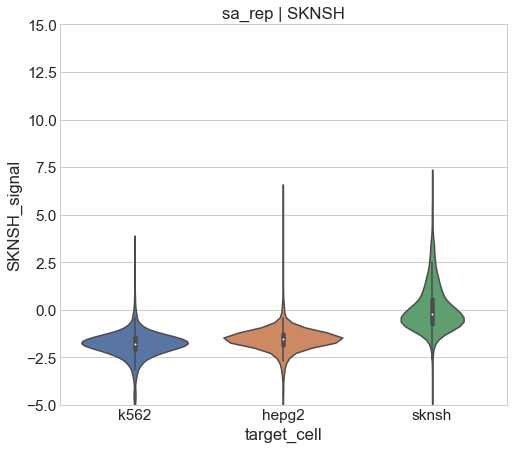

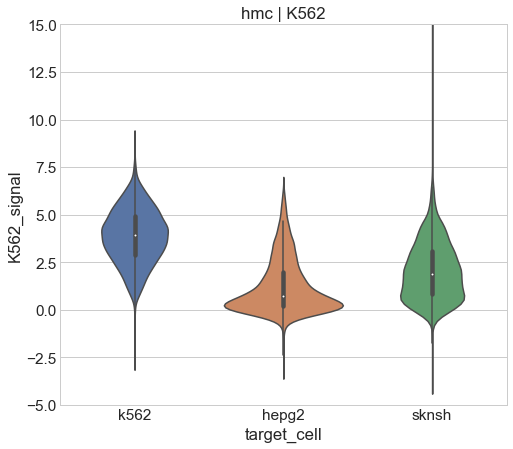

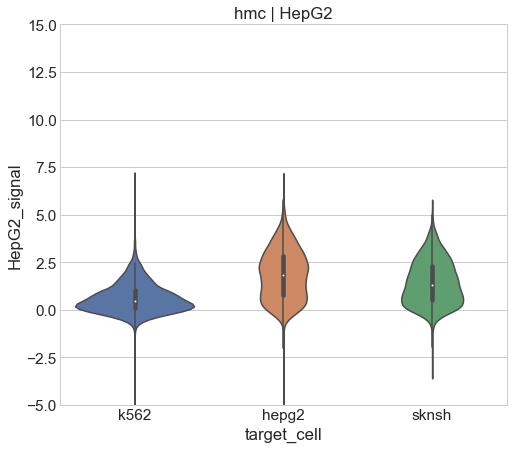

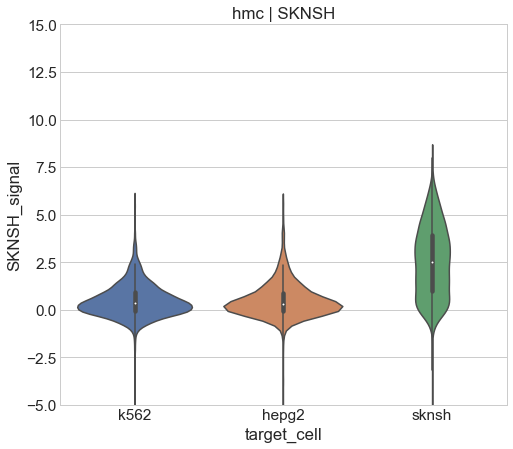

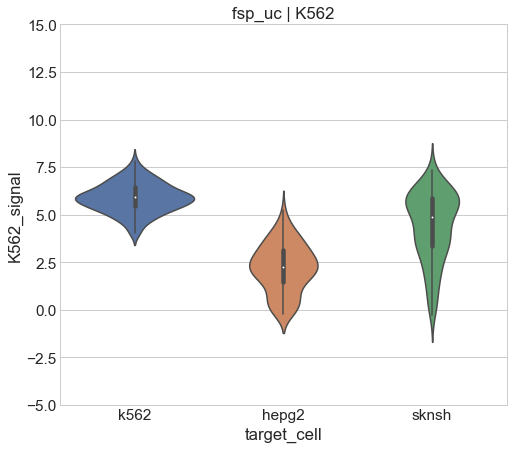

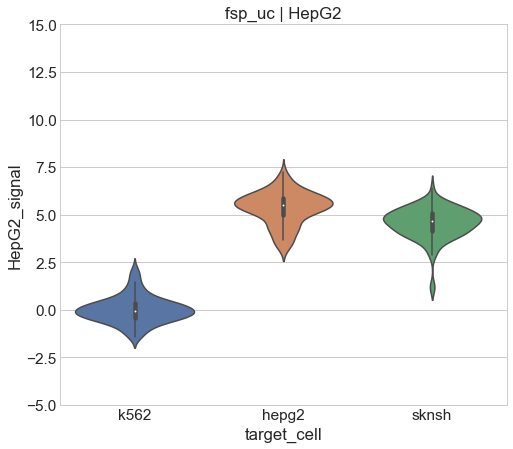

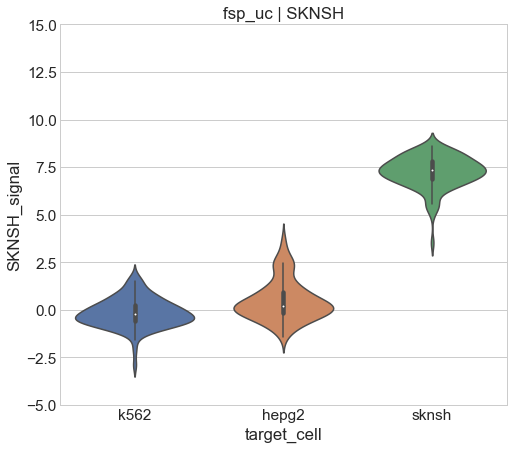

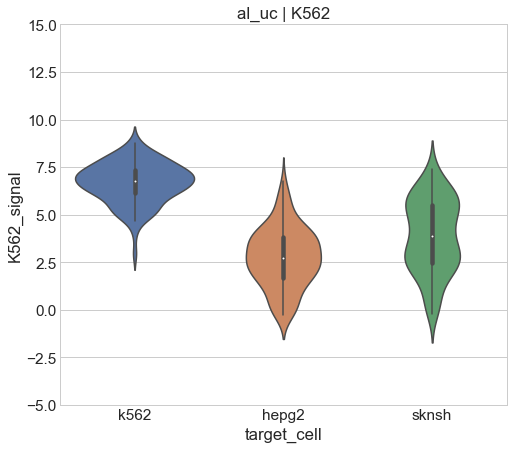

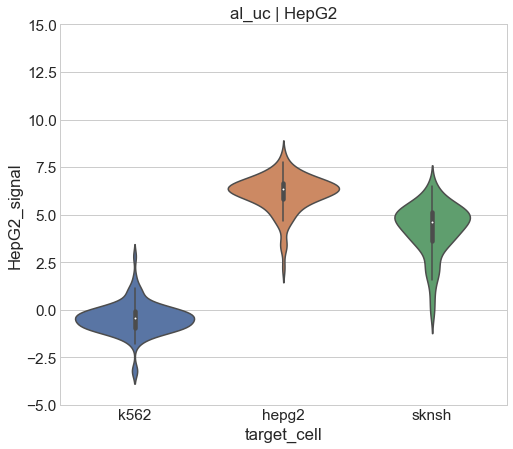

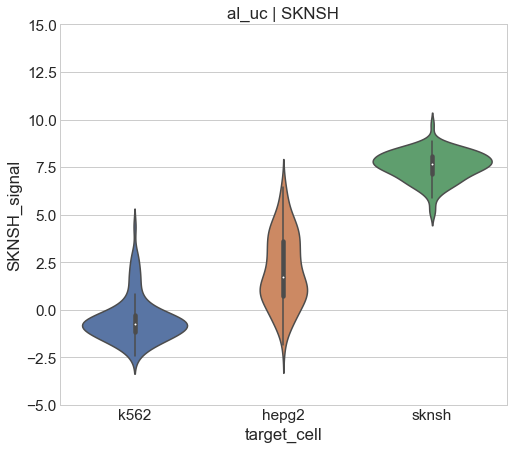

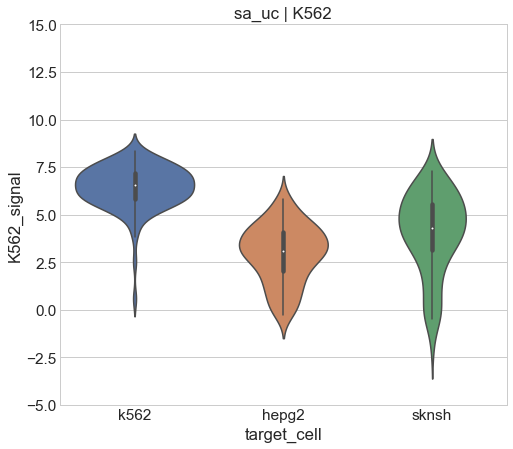

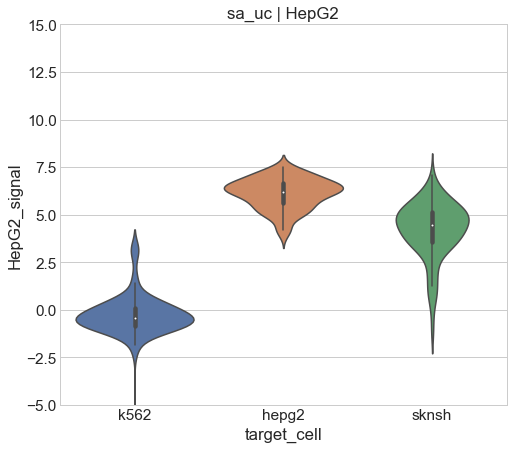

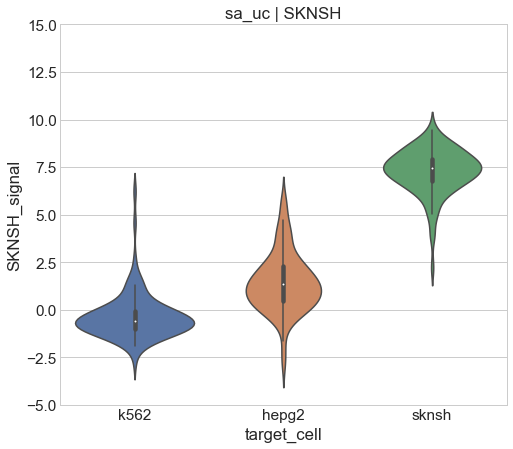

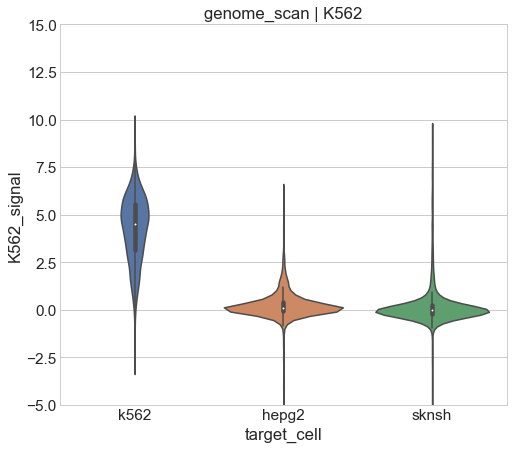

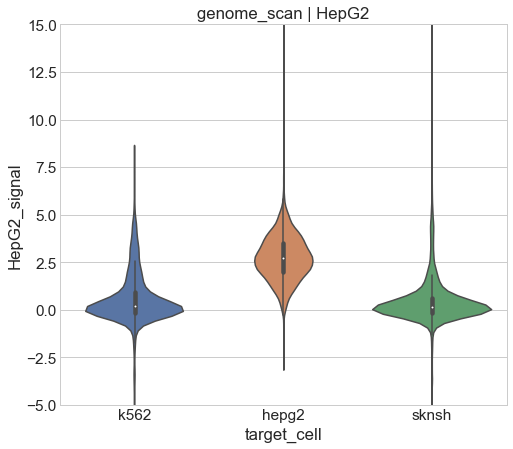

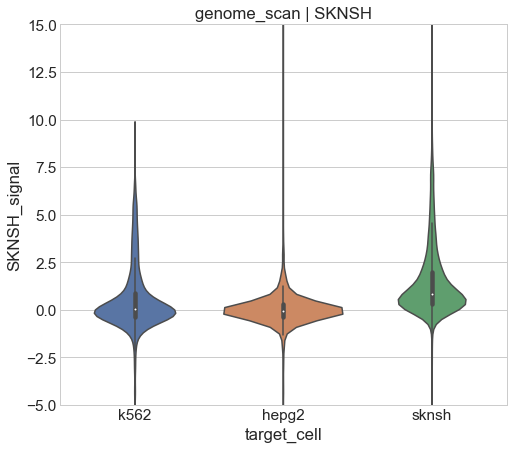

In [127]:
all_methods = ['DHS', 'fsp', 'al', 'sa', 'sa_rep', 'hmc', 'fsp_uc', 'al_uc', 'sa_uc', 'genome_scan']
cell_types = ['K562', 'HepG2', 'SKNSH']
target_cells = ['k562', 'hepg2', 'sknsh']
#colormaps = ['winter', 'autumn', 'summer']
sns.set(font_scale = 1.4)
with plt.style.context('seaborn-whitegrid'):
    for method in all_methods:
        if method in ['fsp', 'al', 'sa']:
            row_filter = (boda2_df['method'] == method) & (boda2_df['round'] == '0')
        else:
            row_filter = (boda2_df['method'] == method)
        plot_df = boda2_df[row_filter].copy()
        for color_idx, cell_type in enumerate(cell_types):   
            plt.figure(figsize=(8,7))
#             sns.scatterplot(data=plot_df, x=f'{cell_type}_signal', y=f'{cell_type}_pred', hue='target_cell', s=10.0, alpha=0.5,
#                            hue_order=target_cells)
            sns.violinplot(data=plot_df, x='target_cell', y=f'{cell_type}_signal', inner='box', order=target_cells)
            #plt.plot((-5,15), (-5,-15), color='black', linestyle='--', alpha=0.5)
            #plt.xlim(-5,15)
            plt.ylim(-5,15)
            plt.title(f'{method} | {cell_type}')#, fontsize=16)
            plt.show()

In [111]:
boda2_df

,ID,sequence,K562_pred,HepG2_pred,SKNSH_pred,K562_pred_aggreg,HepG2_pred_aggreg,SKNSH_pred_aggreg,project,K562_signal,K562_lfcSE,HepG2_signal,HepG2_lfcSE,SKNSH_signal,SKNSH_lfcSE,method,target_cell,round
0,20211210_200256__612928__5::fsp_uc__hepg2__0,CAATCTGTTCCCACCATCAGGTTACTGGTTAATCATTAACCAGGGC...,-0.055265,14.231705,0.080212,0.140002,14.336414,0.227027,BODA:hepg2,2.520816,0.316205,5.287727,0.309186,0.605723,0.208455,fsp_uc,hepg2,NaN
1,20211210_200256__612928__12::fsp_uc__hepg2__0,GGAGCTCTTTCAATGCCAGGCAGGCCCGTGGTGCAGTAAAGGCCTG...,-0.019169,19.914394,0.777519,-0.011601,18.561650,0.767500,BODA:hepg2,0.609272,0.285060,6.402153,0.301327,0.271218,0.340279,fsp_uc,hepg2,NaN
2,20211210_200256__612928__47::fsp_uc__hepg2__0,GGTTCAAAGTCCAGTCACAGTCCAAAGTCCACTCTTTGTCCAAGAG...,-0.146010,12.227689,-0.400996,-0.034775,10.825762,-0.337030,BODA:hepg2,1.486130,0.271874,4.276053,0.366801,-0.578350,0.241865,fsp_uc,hepg2,NaN
3,20211210_200256__612928__69::fsp_uc__hepg2__0,TAATAGTATGTCATCGTAATATGCGGACTTTGAACCGTGTACCAGG...,1.216181,18.812680,1.589409,1.416824,17.606884,1.713512,BODA:hepg2,2.440630,0.219559,5.615395,0.313984,1.063669,0.230603,fsp_uc,hepg2,NaN
4,20211210_200256__612928__93::fsp_uc__hepg2__0,AACACGGGCACGGGGGGGCGCTGTTTGAGTTTAAAAACGATCTAGG...,1.832291,18.612158,1.411221,2.409507,17.280722,2.059474,BODA:hepg2,3.765216,0.570148,4.683140,0.612207,0.171043,2.165178,fsp_uc,hepg2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120052,ORF54316:2538:1300-1500,CTCGGAGTTCAAGAAAATCATCTCACACGGCCGTCTCAGACCCTTC...,-0.119510,1.166959,-0.200713,-0.158865,1.282273,-0.275202,MPRA:ORF_negCtrl,-0.315267,0.384919,0.591628,0.363142,0.068697,0.275408,NaN,NaN,NaN
120053,ORF53130:1455:400-600,GCAATCCTACCCAGACAGATGCAGACAGCGACCTGGTGGGGGATGT...,-0.301822,-0.577524,-0.384271,-0.247987,-0.644892,-0.367910,MPRA:ORF_negCtrl,-0.134821,0.178379,-0.359782,0.261176,-0.022281,0.200300,NaN,NaN,NaN
120054,ORF55877:2391:1900-2100,CCTATGCTGCCTCCTATGCCCTTGTCATCATTGCCATTTTTGAGCT...,1.219841,1.099753,0.645146,0.524327,0.483457,0.248783,MPRA:ORF_negCtrl,0.646673,0.259927,0.489900,0.190735,0.462366,0.111966,NaN,NaN,NaN
120055,ORF52950:2193:400-600,AGCCACAACAAAACAGCCAGTTAATGTGGAAACAAGGTCGACAACT...,0.132379,0.718228,0.953675,0.085746,0.563376,0.668541,MPRA:ORF_negCtrl,-0.061676,0.171760,-0.014411,0.199712,0.239693,0.166026,NaN,NaN,NaN


In [113]:
def over_max_bent(x, bias_cell=0, bending_factor=1.0):
    x = x - bending_factor * (torch.exp(-x) - 1)
    target = x[...,bias_cell]
    non_target_max = x[...,[ i for i in range(x.shape[-1]) if i != bias_cell]].max(-1).values
    return target - non_target_max

In [125]:
signal_tensor = torch.tensor(boda2_df[['K562_signal', 'HepG2_signal', 'SKNSH_signal']].to_numpy())
pred_tensor = torch.tensor(boda2_df[['K562_pred', 'HepG2_pred', 'SKNSH_pred']].to_numpy())

K562_OverMaxB = over_max_bent(signal_tensor, bias_cell=0)
HepG2_OverMaxB = over_max_bent(signal_tensor, bias_cell=1)
SKNSH_OverMaxB = over_max_bent(signal_tensor, bias_cell=2)

K562_OverMaxB_pred = over_max_bent(pred_tensor, bias_cell=0)
HepG2_OverMaxB_pred = over_max_bent(pred_tensor, bias_cell=1)
SKNSH_OverMaxB_pred = over_max_bent(pred_tensor, bias_cell=2)

In [126]:
# boda2_df['K562_OverMaxB'] = K562_OverMaxB
# boda2_df['HepG2_OverMaxB'] = HepG2_OverMaxB
# boda2_df['SKNSH_OverMaxB'] = SKNSH_OverMaxB

boda2_df['K562_OverMaxB_pred'] = K562_OverMaxB_pred
boda2_df['HepG2_OverMaxB_pred'] = HepG2_OverMaxB_pred
boda2_df['SKNSH_OverMaxB_pred'] = SKNSH_OverMaxB_pred

In [124]:
plot_df.loc[plot_df['target_cell'] == 'k562'].K562_OverMaxB

105900         NaN
105901    5.524037
105902    4.695515
105903    6.422027
105904         NaN
            ...   
109895    4.554144
109896    1.805576
109897    2.683502
109898    4.264414
109899    4.761317
Name: K562_OverMaxB, Length: 4000, dtype: float64

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


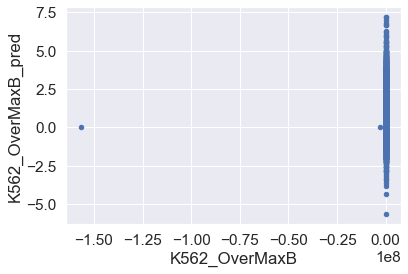

In [136]:
boda2_df.loc[(boda2_df['target_cell'] == 'k562') & (boda2_df['method'] == 'DHS')].plot(kind='scatter', x='K562_OverMaxB', y='K562_OverMaxB_pred')
plt.show()

In [137]:
# out_df = boda2_df.copy()
# out_df.to_csv('/Users/castrr/Dropbox (JAX)/Datasets/BODA2/BODA2_MPRA_results_pred_v2.txt', index=None, sep=' ')

In [138]:
def bending(x, bending_factor=1.0):
    return x - bending_factor * (np.exp(-x) - 1)

In [150]:
x1, x2 = 3, 1
bending(x1), bending(x2), bending(x1) - bending(x2)

(3.950212931632136, 1.6321205588285577, 2.3180923728035783)